In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import subprocess
import pickle
import json
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from base import ModelHelper
import xgboost

%load_ext autoreload
%autoreload 2

In [2]:
model_helper = ModelHelper("./categorical_and_pca", "categorical_and_pca_model")
model_helper

Model Folder = ./categorical_and_pca
Metadata Folder = ./categorical_and_pca/metadata
Path to data = ./raw-data/full_data.gz
Path to test data = ./raw-data/test_labelled.gz
Path to evaluation folder = ./categorical_and_pca/evaluation
Seed = 1

In [3]:
df = model_helper.prepare_data(model_helper.path_to_full_data)
test = model_helper.prepare_data(model_helper.path_to_test_data)

In [4]:
process = subprocess.Popen("cat ./raw-data/feature_names.txt | grep 'symbolic'",
                           shell=True,
                           stdout=subprocess.PIPE)
process.wait()
stdout = process.stdout.read().decode().strip('\n').split('\n')
symbolic_cols = [feature.split(':')[0] for feature in stdout]
symbolic_cols

['protocol_type',
 'service',
 'flag',
 'land',
 'logged_in',
 'is_host_login',
 'is_guest_login']

In [5]:
categorical_features = [col for col in df.columns
                        if col in symbolic_cols or any([feature in col for feature in symbolic_cols])]

In [6]:
df = df[[*categorical_features, 'target']]
test = test[[*categorical_features, 'target']]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074992 entries, 0 to 1074991
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype
---  ------              --------------    -----
 0   service             1074992 non-null  int64
 1   land                1074992 non-null  int64
 2   logged_in           1074992 non-null  int64
 3   is_host_login       1074992 non-null  int64
 4   is_guest_login      1074992 non-null  int64
 5   protocol_type_icmp  1074992 non-null  uint8
 6   protocol_type_tcp   1074992 non-null  uint8
 7   protocol_type_udp   1074992 non-null  uint8
 8   flag_OTH            1074992 non-null  uint8
 9   flag_REJ            1074992 non-null  uint8
 10  flag_RSTO           1074992 non-null  uint8
 11  flag_RSTOS0         1074992 non-null  uint8
 12  flag_RSTR           1074992 non-null  uint8
 13  flag_S0             1074992 non-null  uint8
 14  flag_S1             1074992 non-null  uint8
 15  flag_S2             1074992 non-null  uint8
 16  

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77291 entries, 0 to 77290
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   service             77291 non-null  int64
 1   land                77291 non-null  int64
 2   logged_in           77291 non-null  int64
 3   is_host_login       77291 non-null  int64
 4   is_guest_login      77291 non-null  int64
 5   protocol_type_icmp  77291 non-null  uint8
 6   protocol_type_tcp   77291 non-null  uint8
 7   protocol_type_udp   77291 non-null  uint8
 8   flag_OTH            77291 non-null  uint8
 9   flag_REJ            77291 non-null  uint8
 10  flag_RSTO           77291 non-null  uint8
 11  flag_RSTOS0         77291 non-null  uint8
 12  flag_RSTR           77291 non-null  uint8
 13  flag_S0             77291 non-null  uint8
 14  flag_S1             77291 non-null  uint8
 15  flag_S2             77291 non-null  uint8
 16  flag_S3             77291 non-null  uint

In [9]:
def dimension_reduction_transformation(df, scaler=None, pca=None, min_dim_remove=None):
    df_cat = df[[col for col in df.columns if col != 'target']]
    min_dim_remove = 7 if min_dim_remove is None else min_dim_remove
    if scaler is None or 'n_samples_seen_' not in vars(scaler):
        scaler = StandardScaler()
        rescaled_floats = scaler.fit_transform(df_cat)
    else:
        rescaled_floats = scaler.transform(df_cat)
    if pca is None or 'n_samples_' not in vars(pca):
        pca = PCA(random_state=1)
        rescaled_transformed_floats = pca.fit_transform(rescaled_floats)
    else:
        rescaled_transformed_floats = pca.transform(rescaled_floats)
    rescaled_transformed_floats = pd.DataFrame(rescaled_transformed_floats)
    rescaled_transformed_floats.columns = [f"PCA{i}" for i in range(1, rescaled_transformed_floats.shape[1] + 1)]
    rescaled_transformed_floats["target"] = df["target"].copy()
    rescaled_transformed_floats.drop(columns=[f"PCA{i}" for i in range(min_dim_remove, rescaled_transformed_floats.shape[1])], inplace=True)
    return rescaled_transformed_floats, scaler, pca

In [10]:
scaler = StandardScaler()
pca = PCA(random_state=model_helper.seed)
df, scaler, pca = dimension_reduction_transformation(df, min_dim_remove=13)

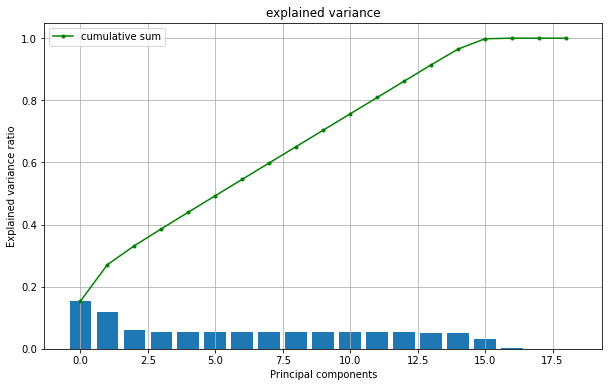

In [11]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance)), explained_variance, align='center')
plt.plot(range(len(explained_variance)), explained_variance.cumsum(), marker='.', color='g', label='cumulative sum')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('explained variance')
plt.legend()
plt.grid()

In [12]:
test, scaler, pca = dimension_reduction_transformation(test, scaler, pca, min_dim_remove=13)

In [13]:
X_train = df[[col for col in df.columns if col != 'target']]
y_train = df['target']
X_test = test[[col for col in test.columns if col != 'target']]
y_test = test['target']

In [14]:
xgb_model = xgboost.XGBClassifier(random_state=model_helper.seed)

In [15]:
best_params = model_helper.random_grid_search(
    X_train, y_train,
    model=xgb_model,
    n_iter=25
)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 1

In [16]:
best_params

{'subsample': 0.75,
 'n_estimators': 50,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 5}

In [17]:
xgb_model = xgboost.XGBClassifier(**best_params, random_state=model_helper.seed)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.00711	validation_1-error:0.07119
[1]	validation_0-error:0.00711	validation_1-error:0.07119
[2]	validation_0-error:0.00711	validation_1-error:0.07464
[3]	validation_0-error:0.00711	validation_1-error:0.07464
[4]	validation_0-error:0.00711	validation_1-error:0.07464
[5]	validation_0-error:0.00711	validation_1-error:0.07464
[6]	validation_0-error:0.00711	validation_1-error:0.07464
[7]	validation_0-error:0.00711	validation_1-error:0.07464
[8]	validation_0-error:0.00711	validation_1-error:0.07464
[9]	validation_0-error:0.00711	validation_1-error:0.07119
[10]	validation_0-error:0.00711	validation_1-error:0.07119
[11]	validation_0-error:0.00712	validation_1-error:0.07120
[12]	validation_0-error:0.00712	validation_1-error:0.07120
[13]	validation_0-error:0.00712	validation_1-error:0.07120
[14]	validation_0-error:0.00712	validation_1-error:0.07120
[15]	validation_0-error:0.00712	validation_1-error:0.07120
[16]	validation_0-error:0.00712	validation_1-error:0.07120
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
model_helper.model = xgb_model
model_helper.save_model()

              precision    recall  f1-score   support

      normal       0.91      1.00      0.95     47913
      attack       0.99      0.84      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.93     77291



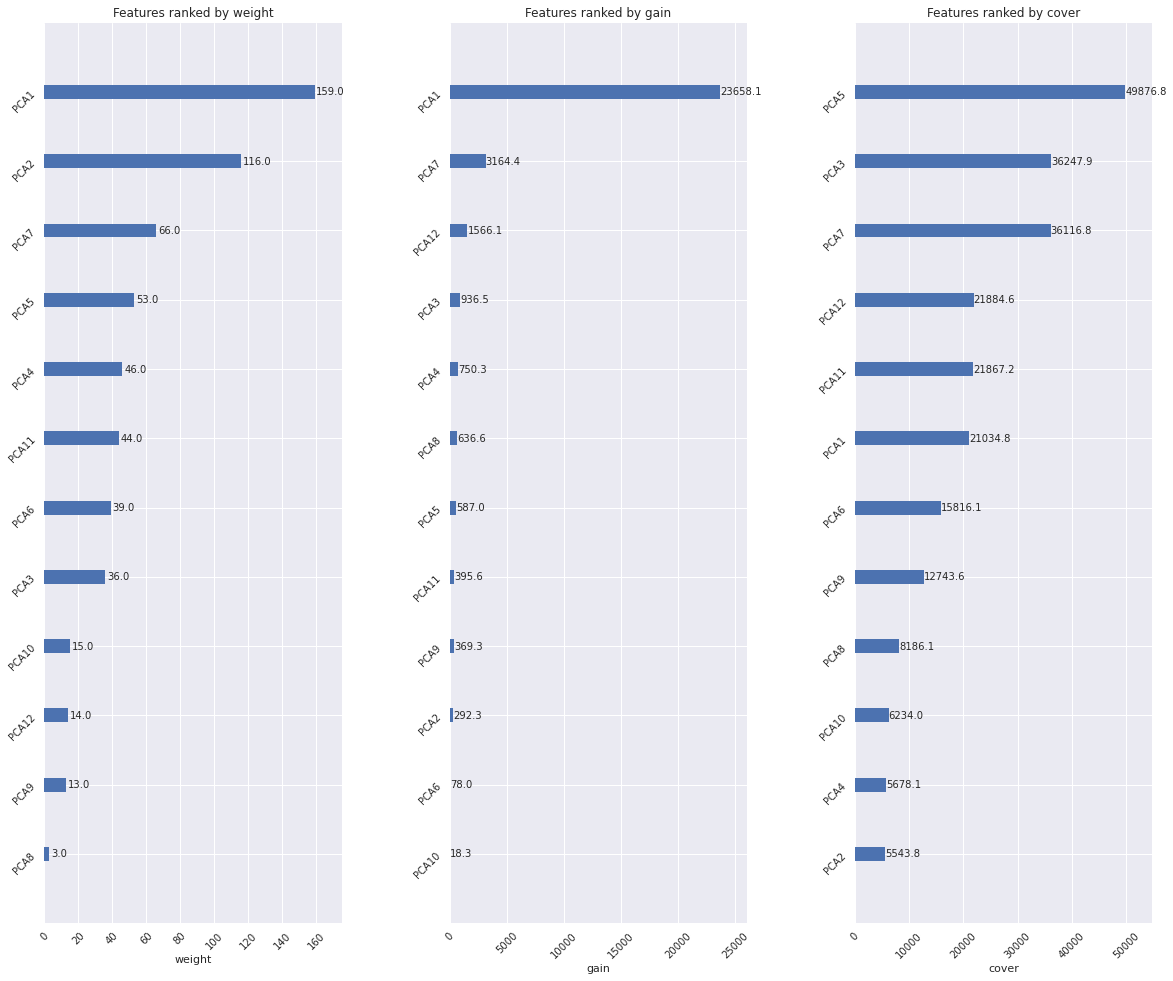

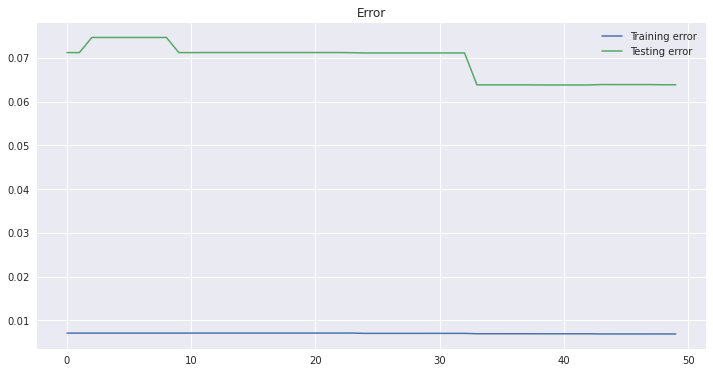

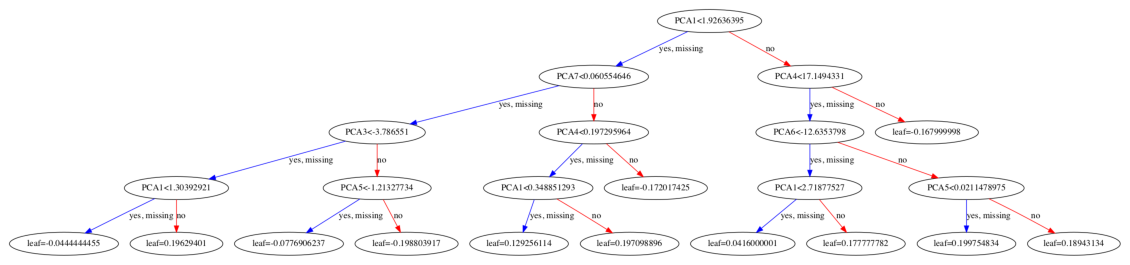

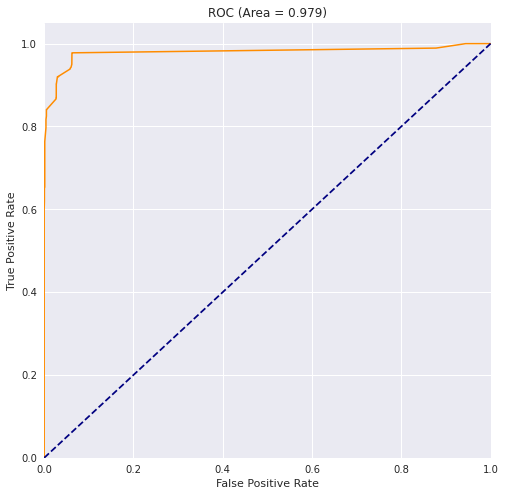

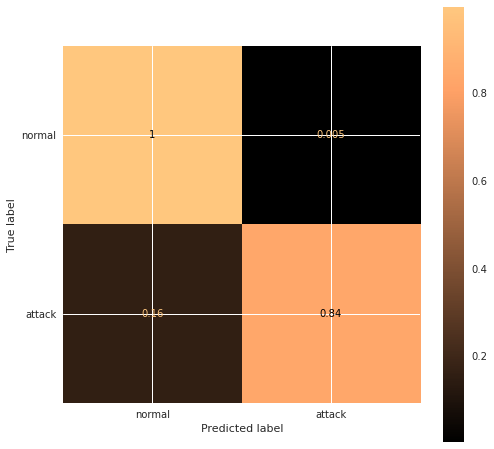

In [19]:
evaluation = model_helper.evaluate_model(X_test, y_test)

In [20]:
evaluation

{'accuracy': 0.936163330788837,
 'balanced_accuracy': 0.8351983263479021,
 'prfs': {'precision': {'normal': 0.9103477247990224,
   'attack': 0.9904100794478774},
  'recall': {'normal': 0.995011792206708, 'attack': 0.840186534141194},
  'f1_score': {'normal': 0.9507987475319598, 'attack': 0.909134438305709},
  'support': {'normal': 47913.0, 'attack': 29378.0}},
 'test_target_proportions': {False: 0.6199039991719605,
  True: 0.38009600082803946},
 'model_params': {'objective': 'binary:logistic',
  'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'colsample_bytree': 1,
  'gamma': 5,
  'gpu_id': -1,
  'importance_type': 'gain',
  'interaction_constraints': '',
  'learning_rate': 0.1,
  'max_delta_step': 0,
  'max_depth': 4,
  'min_child_weight': 1,
  'missing': nan,
  'monotone_constraints': '()',
  'n_estimators': 50,
  'n_jobs': 0,
  'num_parallel_tree': 1,
  'random_state': 1,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': 1,
  '